# Synthetic Data Visualization

In [1]:
import IPython
import os
import json
import random
import numpy as np
import requests
from io import BytesIO
import base64
import cv2
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
from utils.constants import Action
from shapely.geometry import Polygon

In [2]:
# Load the dataset json
class StandardSimDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = dict({'take': (255, 0, 0), 'put': (0, 255, 0), 'shift': (0, 0, 255)})
        
        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()
        
        self.process_info()
        self.process_licenses()
        self.process_categories()
        self.process_images()
        self.process_segmentations()
        
        
    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))
        
        requirements = [['description', str],
                        ['url', str],
                        ['version', str],
                        ['year', int],
                        ['contributor', str],
                        ['date_created', str]]
        for req, req_type in requirements:
            if req not in self.info:
                print('ERROR: {} is missing'.format(req))
            elif type(self.info[req]) != req_type:
                print('ERROR: {} should be type {}'.format(req, str(req_type)))
        print('')

        
    def display_licenses(self):
        print('Licenses:')
        print('=========')
        
        requirements = [['id', int],
                        ['url', str],
                        ['name', str]]
        for license in self.licenses:
            for key, item in license.items():
                print('  {}: {}'.format(key, item))
            for req, req_type in requirements:
                if req not in license:
                    print('ERROR: {} is missing'.format(req))
                elif type(license[req]) != req_type:
                    print('ERROR: {} should be type {}'.format(req, str(req_type)))
            print('')
        print('')
        
    def display_categories(self):
        print('Categories:')
        print('=========')
        for sc_key, sc_val in self.super_categories.items():
            print('  super_category: {}'.format(sc_key))
            for cat_id in sc_val:
                print('    id {}: {}'.format(cat_id, self.categories[cat_id]['name']))
            print('')
    
    def display_image(self, image_id, show_polys=True, show_bbox=True, actions=['take','put','shift']):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))
        
        # Print the image info
        image = self.images[image_id]
        for key, val in image.items():
            print('  {}: {}'.format(key, val))
            
        # Open the image
        image_path = os.path.join(self.image_dir, image['image2'])
        image_pil = PILImage.open(image_path)

        buffer = BytesIO()
        image_pil.save(buffer, format='PNG')
        buffer.seek(0)

        data_uri = base64.b64encode(buffer.read()).decode('ascii')
        image_path = "data:image/png;base64,{0}".format(data_uri)
            
        # Calculate the size and adjusted display size
        max_width = 1280
        image_width, image_height = image_pil.size
        adjusted_width = min(image_width, max_width)
        adjusted_ratio = adjusted_width / image_width
        adjusted_height = adjusted_ratio * image_height
        
        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        all_formatted_points = []
        print('   segmentations:')
        image = cv2.imread(os.path.join(self.image_dir, image['image2']))
        # cv2 reads image in BGR, so convert it to RGB for visualization
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        overlay = image.copy()
        for i, segm in enumerate(self.segmentations[image_id]):
            if segm['action'] in actions:
                polygons_list = []
                # Correct the polygon segmentation point order
                for segmentation_points in segm['segmentation']:
                    segmentation_points = np.multiply(segmentation_points, adjusted_ratio).astype(int)
                    # Switching x,y coords in segmentation points
                    formatted_points = []
                    for i in range(0, len(segmentation_points), 2):
                        formatted_points.append((segmentation_points[i+1], segmentation_points[i]))
                    polygons_list.append(formatted_points)
                
                polygons[segm['id']] = polygons_list
                # Add all polygons to cv2 overlay
                if show_polys:
                    for poly in polygons_list:
                        polygon = Polygon(poly)
                        int_coords = lambda x: np.array(x).round().astype(np.int32)
                        exterior = [int_coords(polygon.exterior.coords)]
                        overlay = cv2.fillPoly(overlay, exterior, color=self.colors[segm['action']])#color=(255, 255, 0)), color=(5*i, 5*i, 0)
                        alpha=0.5
                        image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0, image)
                # Correct bounding box point order
                bbox = segm['bbox']
                bbox_points = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1],
                               bbox[0] + bbox[2], bbox[1] + bbox[3], bbox[0], bbox[1] + bbox[3],
                               bbox[0], bbox[1]]
                bbox_points = np.multiply(bbox_points, adjusted_ratio).astype(int)
                bbox_polygons[segm['id']] = str(bbox_points).lstrip('[').rstrip(']')
                # Add bounding box for this polygon
                if show_bbox:
                    cv2.rectangle(overlay, (int(bbox[1]), int(bbox[0])), (int(bbox[1]+bbox[3]), int(bbox[0]+bbox[2])), (255, 0, 0), 2)
                    cv2.putText(overlay, segm['action'], (int(bbox[1]), int(bbox[0])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
                # Print details
                print('    {}:{}:{}'.format(segm['id'], segm['action'], self.categories[segm['category_id']]))
        
        fig = plt.figure(figsize=(8,6), dpi=200, facecolor='w', edgecolor='k')
        plt.imshow(overlay,)
        plt.axis('off')
        
        return None
        
    def process_info(self):
        self.info = self.coco['info']
    
    def process_licenses(self):
        self.licenses = self.coco['licenses']
    
    def process_categories(self):
        self.categories = {}
        self.super_categories = {}
        for category in self.coco['categories']:
            cat_id = category['id']
            
            # Add category to the categories dict
            if cat_id not in self.categories:
                self.categories[cat_id] = category
            else:
                print("ERROR: Skipping duplicate category id: {}".format(category))
                
    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print("ERROR: Skipping duplicate image id: {}".format(image))
            else:
                self.images[image_id] = image
                
    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [3]:
annotation_path = 'utils/synthetic_anno.json'
image_dir = 'data/renders_multicam_diff_1'

standard_dataset = StandardSimDataset(annotation_path, image_dir)

Image:
  id: 1
  license: 1
  scene: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1
  width: 1280
  height: 720
  randommats1: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-0-randommats.png
  randommats2: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-1-randommats.png
  depth1: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-0-depth0001.exr
  depth2: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-1-depth0001.exr
  image1: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-0.png
  image2: 0101050fe5ed48399f99247e7534d6e2/stcg.us.0003_0101050fe5ed48399f99247e7534d6e2_cam-1_change-1.png
   segmentations:
    3:put:{'id': 0, 'name': 'Cylinder142.005'}
    4:put:{'id': 1, 'name': 'Object001asd.005'}
    5:put:{'id': 2, 'name': 'Box114.0

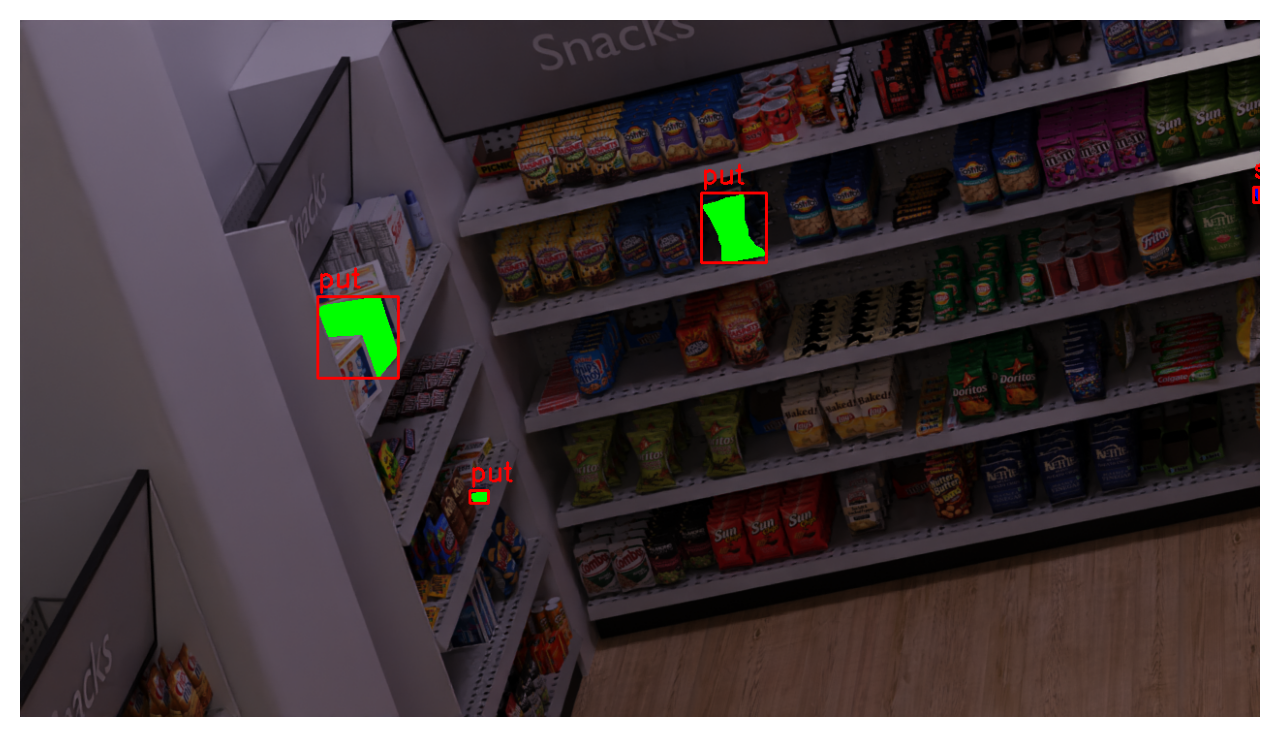

In [4]:
html = standard_dataset.display_image(1, actions=['put', 'shift'])

The following visualizes some change detection image pairs.

In [5]:
# Visualize image pairs
def find_files(root):
    imgs = sorted([filename for filename in glob(f"{root}/*.png") if "change-0" in filename])
    files = []
    for name in imgs:
        label_file1 = name.replace(".png", "-segmentation0001.exr")
        label_file2 = label_file1.replace("change-0", "change-1")
        label_json1 = name.replace(".png", "_label.json")
        label_json2 = label_json1.replace("change-0", "change-1")
        files_exist = (
            os.path.isfile(label_file1)
            and os.path.isfile(label_file2)
            and os.path.isfile(label_json1)
            and os.path.isfile(label_json2)
        )

        if files_exist:
            bbox_json = name.replace("_change-0.png", "-boxes.json")
            label_file = name.replace("_change-0.png", "-label.png")
            files.append(
                {
                    "label1": label_file1,
                    "label2": label_file2,
                    "label": label_file,
                    "label1_json": label_json1,
                    "label2_json": label_json2,
                    "bbox_json": bbox_json,
                }
            )
    return files

data_root = 'data/renders_multicam_diff_1'

files = find_files(data_root)

fig = plt.figure()
i = 1
for f in files[:5]:
    print(f['label'].replace('-label.png', '_change-1.png'))
    # Prepare label
    label = cv2.imread(f["label"])
    removed = label[:, :, 0]
    added = np.where(label[:, :, 1], Action.ADDED.value, 0)
    shifted = np.where(label[:, :, 2], Action.SHIFTED.value, 0)
    # added gets priority (we need to break the tie), then removed, then shifts
    label = np.where(added, added, np.where(removed, removed, shifted)).astype(np.uint8)
    
    ax1 = fig.add_subplot()
    imgplot1 = plt.imshow(PILImage.open(f['label'].replace('-label.png', '_change-0.png')))
    plt.axis('off')
    plt.show()
    ax2 = fig.add_subplot()
    imgplot2 = plt.imshow(PILImage.open(f['label'].replace('-label.png', '_change-1.png')))
    plt.axis('off')
    plt.show()
    ax3 = fig.add_subplot()
    imgplot3 = plt.imshow(label)
    plt.axis('off')
    plt.show()
    i+=1


<Figure size 640x480 with 0 Axes>